In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cartoplot import cartoplot
from netCDF4 import Dataset
import pickle
import tqdm
from ll_xy import lonlat_to_xy
import regrid
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from pyproj import proj
import mask
import pyproj
import cartopy.crs as ccrs
import cartopy

In [5]:
ease_lons, ease_lats = mask.get('lon'), mask.get('lat')

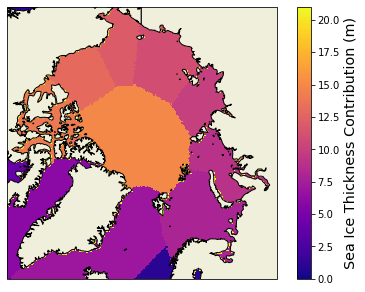

In [6]:
fig = plt.figure(figsize=(7,5))

# ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90))
ax = plt.axes(projection=ccrs.NorthPolarStereo())


ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())    
   
ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

bg = ax.pcolormesh(ease_lons,
                   ease_lats,
                   mask.get('mask')[:-1,:-1],
                    transform=ccrs.PlateCarree(),
                    cmap='plasma')

cb = fig.colorbar(bg, orientation='vertical', shrink=1)

cb.set_label('Sea Ice Thickness Contribution (m)', fontsize = 'x-large')

In [7]:
args = proj.Proj(init='epsg:3408')

PC_CRS = cartopy.crs.epsg(3408)

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [8]:
grids = {}

for i in ['lon','lat']:

    grid = np.array(pd.read_csv(f'/home/robbie/Dropbox/Code/piomas_reader/grids/{i}grid.dat',header=None, delim_whitespace=True))

    flat_grid = grid.ravel()

    shaped_grid = flat_grid.reshape(360,120)
    
    grids[i] = shaped_grid

piolons = grids['lon']
piolats = grids['lat']

In [9]:
pio_x_grid, pio_y_grid = lonlat_to_xy(grids['lon'],grids['lat'],hemisphere='n')

points = np.column_stack((pio_x_grid.ravel(),pio_y_grid.ravel()))

tri = Delaunay(points)  # Compute the triangulation

args = proj.Proj(proj="aeqd", lat_0=90, lon_0=0, datum="WGS84", units="m")

crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic

xout, yout = pyproj.transform(crs_wgs, args, np.array(ease_lons),np.array(ease_lats))

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj

In [10]:
def get_daily_flux_data(year,month):
    preamble = '/media/robbie/TOSHIBA EXT/awi_cs2_smos/processed'
    d = Dataset(f'{preamble}/{year}{str(month).zfill(2)}.nc')
    return d  

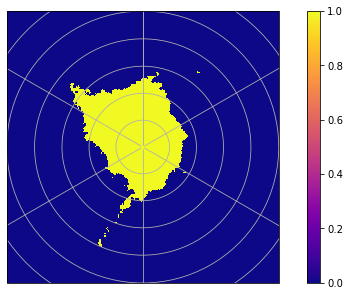

In [11]:
mymask = mask.get('mask')
persistent_ice = pickle.load(open('../pickles/m_min.p','rb'))

persistent_ice = pickle.load(open('../pickles/sz.p','rb'))

cartoplot(ease_lons, ease_lats, persistent_ice,land=False)

In [12]:
def get_f28(year):
    if year < 2020:
        d = Dataset(f'/media/robbie/TOSHIBA EXT/conc_feb28/seaice_conc_daily_nh_f17_{year}0228_v03r01.nc')
    elif year == 2020:
        d = Dataset(f'/media/robbie/TOSHIBA EXT/conc_feb28/seaice_conc_daily_icdr_nh_f18_20200228_v01r00.nc')
    elif year == 2021:
        d = Dataset(f'/media/robbie/TOSHIBA EXT/conc_feb28/seaice_conc_daily_icdr_nh_f18_20210228_v01r00.nc')
    else: raise
        
    conc = d['seaice_conc_cdr'][0]
    lons = np.array(d['longitude'])
    lats = np.array(d['latitude'])
        
    conc_ease = regrid.regrid(conc,lons,lats,ease_lons,ease_lats,method='linear')
    
    return(conc_ease)
    
f28_concs = {}

for year in tqdm.trange(2010,2022):
    
    f28_concs[year] = get_f28(year)
    
    print(get_f28(year).shape)
    
    break

  0%|          | 0/12 [00:00<?, ?it/s]/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  # Remove the CWD from sys.path while we load stuff.
  0%|          | 0/12 [00:06<?, ?it/s]

(361, 361)


100%|██████████| 11/11 [00:00<00:00, 179.88it/s]


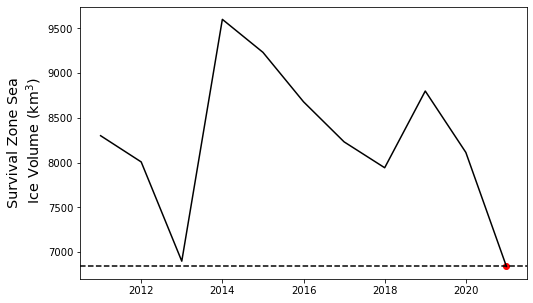

In [25]:

transient_frac = []
p_vols = []
t_vols = []


for year in tqdm.trange(2011,2022):
    feb_sit = get_daily_flux_data(year,2)['sit'][-1]
    
#     cartoplot(ease_lons,ease_lats, feb_sit)
#     basin_sit = mask.select_region('basin', feb_sit)
    basin_sit = feb_sit
    
    #Persistent and transient SIT
    
    p_sit = np.ma.masked_where(persistent_ice!=1, basin_sit)
    
    t_sit = np.ma.masked_where(persistent_ice==1, basin_sit)
    
    p_sit = np.ma.filled(p_sit, np.nan)
    t_sit = np.ma.filled(t_sit, np.nan)

#     cartoplot(ease_lons, ease_lats, t_sit)
#     cartoplot(ease_lons, ease_lats, p_sit)
    
    p_vol = np.nansum(p_sit)*628.35e6/1e9
    t_vol = np.nansum(t_sit)*628.35e6/1e9
    
    
    
    p_vols.append(p_vol)
    
    t_vols.append(t_vol)
    
    
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(range(2011,2022),p_vols, color='k')
km3 = r'km$^3$'
ax.set_ylabel(f'Survival Zone Sea\n Ice Volume ({km3})',fontsize='x-large')
ax.scatter(2021,p_vols[-1], color='r',marker='o')
ax.axhline(p_vols[-1],ls='--',color='k')

pickle.dump(p_vols,open('../pickles/survival_zone.p','wb'))

In [ ]:
cbd = '/home/robbie/Dropbox/beaufort_sea/piomas/raw/conc/aiday.H1979'

d = np.fromfile(cbd, dtype=np.float32)

daysinyear = 365

d = np.reshape(d, (daysinyear,360,120))

cartoplot(piolons,piolats,d[0])

In [26]:
feb_vols_awi = {}
dec_vols_awi = {}
feb_vols_pio = {}
dec_vols_pio = {}

regions = ['basin','Kara','Laptev','East Siberian','Chukchi','Beaufort','Central Arctic','Greenland']

for year in tqdm.trange(1979,2022):
    
    bd = f'/home/robbie/Dropbox/beaufort_sea/piomas/raw/sit/hiday.H{year}'
    cbd = f'/home/robbie/Dropbox/beaufort_sea/piomas/raw/conc/aiday.H{year}'
    
    if year > 2009:    
        
        # Get Feb volumes
        
        try:
            feb_sit = get_daily_flux_data(year,2)['sit'][-1]
            
            feb_dict = {'total':np.nansum(feb_sit)*628.35e6}
            
            for region in regions:
                
                region_sit = mask.select_region(region,feb_sit)
                
                feb_dict[region] = np.nansum(region_sit)*628.35e6

        except:
            feb_dict = {'total':np.nan}
            for region in regions: feb_dict[region] = np.nan
                
        try:
            if year == 2021:raise
                
            dec_sit = get_daily_flux_data(year,12)['sit'][-1]
            
            dec_dict = {'total':np.nansum(dec_sit)*628.35e6}
            
            for region in regions:
                
                region_sit = mask.select_region(region,dec_sit)
                
                dec_dict[region] = np.nansum(region_sit)*628.35e6

        except:
            dec_dict = {'total':np.nan}
            for region in regions: dec_dict[region] = np.nan
                
        feb_vols_awi[year] = feb_dict
        dec_vols_awi[year] = dec_dict
            
    
#     d = np.fromfile(bd, dtype=np.float32)
#     cd = np.fromfile(cbd, dtype=np.float32)
    
#     d = np.multiply(d,cd)
    
#     daysinyear = 365 if year != 2021 else 59
    
#     d = np.reshape(d, (daysinyear,360,120))

#     feb = d[58]
#     dec = d[-31]
    
#     interpolator = LinearNDInterpolator(tri, feb.ravel())
#     ease_feb = interpolator((xout,yout))
    
#     interpolator = LinearNDInterpolator(tri, dec.ravel())
#     ease_dec = interpolator((xout,yout))
    
#     mf = mask.select_region('basin',ease_feb)
#     md = mask.select_region('basin',ease_dec)
     
#     feb_vols_pio[year] = {'pio_all':np.nansum(ease_feb)*628.35e6,
#                           'pio_mas':np.nansum(mf)*628.35e6,
#                      }
#     dec_vols_pio[year] = {'pio_all':np.nansum(ease_dec)*628.35e6,
#                           'pio_mas':np.nansum(md)*628.35e6,
#                          }

100%|██████████| 43/43 [00:00<00:00, 58.55it/s] 


In [27]:
feb_vols_awi.keys()

dict_keys([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [28]:
awi_mas, pio_mas, awi_all, pio_all = [], [], [] ,[]


for year in tqdm.trange(2011,2022):

    awi_mas.append(( feb_vols_awi[year]['basin']     - dec_vols_awi[year-1]['basin']  )/1e12)
    pio_mas.append(( feb_vols_pio[year]['pio_mas']     - dec_vols_pio[year-1]['pio_mas']  )/1e12)
    
    
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(2011,2022), awi_mas,color='crimson',ls='-',label='CS2-SMOS')
ax.plot(np.arange(2011,2022), pio_mas,color='darkblue',ls='-',label='PIOMAS')


ax.axhline(pio_mas[-1],color='darkblue', ls='--')
ax.axhline(awi_mas[-1],color='crimson', ls='--')


ax.xaxis.set_ticks_position('both')
units = r'(10$^3$ km$^3$)'
ax.set_ylabel(f'DJF Arctic Basin Volume \n Change {units}',fontsize='x-large')

plt.legend()

  0%|          | 0/11 [00:00<?, ?it/s]


KeyError: 2011

# Plot regional DJF growth as % of basin growth

100%|██████████| 11/11 [00:00<00:00, 58254.22it/s]


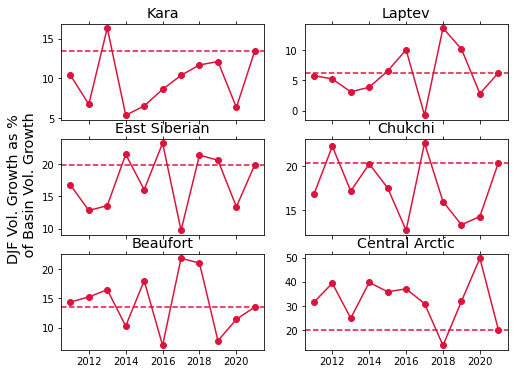

In [29]:
fig, axs = plt.subplots(3,2,figsize=(8,6))

for region, ax in zip(regions[1:], axs.reshape(-1)):

    awi_mas, pio_mas, awi_all, pio_all = [], [], [] ,[]

    for year in tqdm.trange(2011,2022):

        basin_growth = feb_vols_awi[year]['basin'] -dec_vols_awi[year-1]['basin']
        
        region_growth = feb_vols_awi[year][region]  -dec_vols_awi[year-1][region]
        
        awi_mas.append(( region_growth/basin_growth )*100)


    ax.plot(np.arange(2011,2022), awi_mas,color='crimson',ls='-',label='CS2-SMOS',marker='o')

    # ax.plot(np.arange(2011,2022), pio_mas,color='darkblue',ls='-',label='PIOMAS')

    ax.axhline(awi_mas[-1],color='crimson', ls='--')

    ax.xaxis.set_ticks_position('both')
    
    if region not in ['Beaufort', 'Central Arctic']:
        ax.set_xticklabels([])
    
    units = r'(10$^3$ km$^3$)'
    
    if region == 'East Siberian':
        ax.set_ylabel(f'DJF Vol. Growth as % \n of Basin Vol. Growth',fontsize='x-large')

    ax.set_title(region,fontsize='x-large')
    
plt.show()

# Plot regional end of feb volume as % of basin vol

100%|██████████| 11/11 [00:00<00:00, 153280.21it/s]


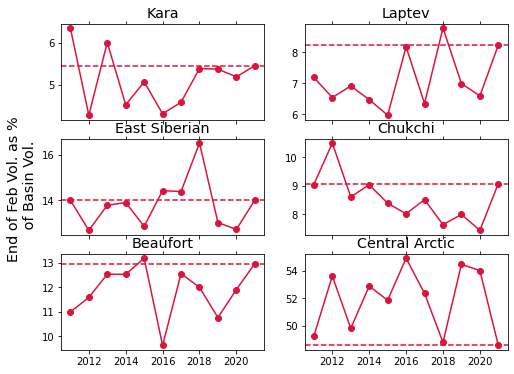

In [20]:
fig, axs = plt.subplots(3,2,figsize=(8,6))

for region, ax in zip(regions[1:], axs.reshape(-1)):

    awi_mas, pio_mas, awi_all, pio_all = [], [], [] ,[]

    for year in tqdm.trange(2011,2022):

        basin_growth = feb_vols_awi[year]['basin'] 
        
        region_growth = feb_vols_awi[year][region] 
        
        awi_mas.append(( region_growth/basin_growth )*100)

    if region == 'Chukchi':       chuk_feb_vol = awi_mas
    if region == 'Beaufort':      beau_feb_vol = awi_mas
        
    ax.plot(np.arange(2011,2022), awi_mas,color='crimson',ls='-',label='CS2-SMOS',marker='o')

    # ax.plot(np.arange(2011,2022), pio_mas,color='darkblue',ls='-',label='PIOMAS')

    ax.axhline(awi_mas[-1],color='crimson', ls='--')

    ax.xaxis.set_ticks_position('both')
    
    if region not in ['Beaufort', 'Central Arctic']:
        ax.set_xticklabels([])
    
    units = r'(10$^3$ km$^3$)'
    
    if region == 'East Siberian':
        ax.set_ylabel(f'End of Feb Vol. as % \n of Basin Vol.',fontsize='x-large')

    ax.set_title(region,fontsize='x-large')
    
plt.show()

In [22]:
from scipy.stats import linregress

pickle.dump(chuk_feb_vol, open('../figure2_current/chuk.p','wb'))
pickle.dump(beau_feb_vol, open('../figure2_current/beau.p','wb'))

LinregressResult(slope=-0.15193402667355202, intercept=314.8612619278364, rvalue=-0.5879286674096654, pvalue=0.057133482825139296, stderr=0.06968043481397902, intercept_stderr=140.47592940341414)


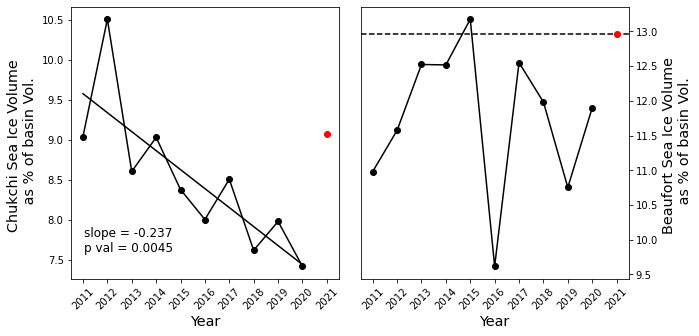

In [30]:
fig, (ax,ax2) = plt.subplots(1,2, figsize=(10,5))

ax.plot(np.arange(2011,2021), chuk_feb_vol[:-1],marker='o',color='k')
ax.scatter(2021, chuk_feb_vol[-1],color='r')

z = np.polyfit(np.arange(2011,2021), chuk_feb_vol[:-1], 1)
p = np.poly1d(z)
ax.plot(np.arange(2011,2021), p(np.arange(2011,2021)),color='k')

ax.set_ylabel('Chukchi Sea Ice Volume \n as % of basin Vol.', fontsize='x-large')
ax.set_xlabel('Year', fontsize='x-large')

stats_full = linregress(np.arange(2011,2022), chuk_feb_vol[:])

print(stats_full)

stats = linregress(np.arange(2011,2021), chuk_feb_vol[:-1])

ax.annotate(text=f'slope = {np.round(stats[0],decimals=3)}\np val = {np.round(stats[3],decimals=4)}',
             xy=(0.05,0.1),
             fontsize='large',
             xycoords='axes fraction')

ax.set_xticks(np.arange(2011,2022))
ax.set_xticklabels(np.arange(2011,2022),rotation=45)

###############################################################

ax2.plot(np.arange(2011,2021), beau_feb_vol[:-1],marker='o',color='k')


ax2.set_ylabel('Beaufort Sea Ice Volume \n as % of basin Vol.', fontsize='x-large')
ax2.set_xlabel('Year', fontsize='x-large')

ax2.axhline(beau_feb_vol[-1],ls='--',color='k')
ax2.scatter(2021, beau_feb_vol[-1],color='r',zorder=10)

ax2.set_xticks(np.arange(2011,2022))
ax2.set_xticklabels(np.arange(2011,2022),rotation=45)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

plt.subplots_adjust(wspace=0.08,)


overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/Beaufort'
plt.savefig(f'{overleaf_dir}/Sup_figs/regional_vol_fracs.jpg',dpi=500,bbox_inches='tight')


plt.show()

# Plot DJF Growth in Absolute Terms

100%|██████████| 11/11 [00:00<00:00, 97956.14it/s]


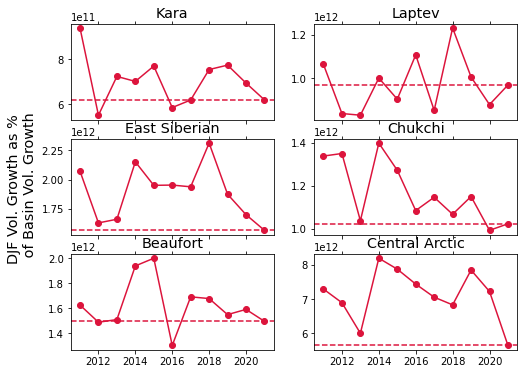

In [18]:
fig, axs = plt.subplots(3,2,figsize=(8,6))

for region, ax in zip(regions[1:], axs.reshape(-1)):

    awi_mas, pio_mas, awi_all, pio_all = [], [], [] ,[]

    for year in tqdm.trange(2011,2022):

#         basin_growth = feb_vols_awi[year]['basin'] -dec_vols_awi[year-1]['basin']
        
        region_growth = feb_vols_awi[year][region]
        
        awi_mas.append(region_growth)


    ax.plot(np.arange(2011,2022), awi_mas,color='crimson',ls='-',label='CS2-SMOS',marker='o')

    # ax.plot(np.arange(2011,2022), pio_mas,color='darkblue',ls='-',label='PIOMAS')

    ax.axhline(awi_mas[-1],color='crimson', ls='--')

    ax.xaxis.set_ticks_position('both')
    
    if region not in ['Beaufort', 'Central Arctic']:
        ax.set_xticklabels([])
    
    units = r'(10$^3$ km$^3$)'
    
    if region == 'East Siberian':
        ax.set_ylabel(f'DJF Vol. Growth as % \n of Basin Vol. Growth',fontsize='x-large')

    ax.set_title(region,fontsize='x-large')
    
plt.show()

In [12]:
import pickle
t2m = pickle.load(open('../temp_series.p','rb'))
t2m.shape

(42,)

In [64]:
pio_mas = []
awi_mas = []
dec_vol_awi = []
dec_vol_pio = []

for year in tqdm.trange(1980,2022):
    
    if year > 2010:
        awi_mas.append(( feb_vols_awi[year]['basin']     - dec_vols_awi[year-1]['basin']  )/1e12)
        dec_vol_awi.append(dec_vols_awi[year-1]['basin']/1e12)
        
    pio_mas.append(( feb_vols_pio[year]['pio_mas']     - dec_vols_pio[year-1]['pio_mas']  )/1e12)
    dec_vol_pio.append(dec_vols_pio[year-1]['pio_mas']/1e12)

100%|██████████| 42/42 [00:00<00:00, 202950.19it/s]


Text(0.5, 0, 'Dec Vol')

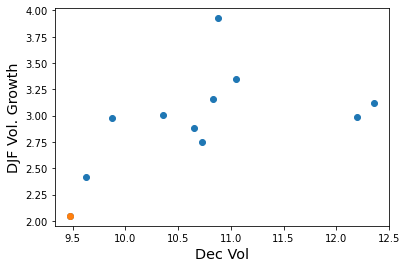

In [68]:
plt.scatter(dec_vol_awi,awi_mas)
plt.scatter(dec_vol_awi[-1],awi_mas[-1])
plt.ylabel('DJF Vol. Growth', fontsize='x-large')
plt.xlabel('Dec Vol', fontsize='x-large')

Text(0.5, 0, 'Dec Vol')

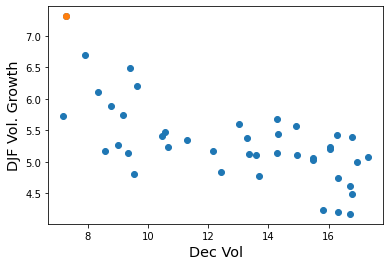

In [69]:
plt.scatter(dec_vol_pio,pio_mas)
plt.scatter(dec_vol_pio[-1],pio_mas[-1])
plt.ylabel('DJF Vol. Growth',fontsize='x-large')
plt.xlabel('Dec Vol',fontsize='x-large')

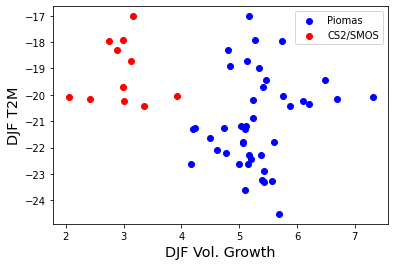

In [59]:
plt.scatter(pio_mas, t2m,color='b', label='Piomas')
plt.scatter(awi_mas, t2m[-11:],color='r',label='CS2/SMOS')
plt.ylabel('DJF T2M', fontsize='x-large')
plt.xlabel('DJF Vol. Growth', fontsize='x-large')
plt.legend()

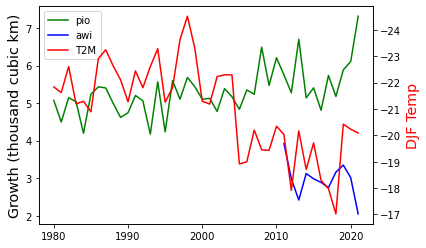

In [45]:
fig, ax = plt.subplots(1,1)
ax.plot(range(1980,2022), pio_mas,color='g',label='pio')
ax.plot(range(2011,2022), awi_mas,color='b',label='awi')
ax.plot([2000],[4],color='r',label='T2M')
ax.set_ylabel('Growth (thousand cubic km)', fontsize='x-large',color='k')
ax2 = ax.twinx()
ax2.plot(range(1980,2022), t2m,color='r',label='t2m')
ax2.set_ylabel('DJF Temp', fontsize='x-large',color='r')
ax2.invert_yaxis()
ax.legend()

In [34]:
from scipy.stats import pearsonr
pearsonr(awi_mas, t2m[-11:])

(0.03609007344761844, 0.916102307882959)

In [37]:
pearsonr(pio_mas, t2m)

(0.19628429018641969, 0.21282311631527326)

In [12]:
sd = {'pio_mas':pio_mas,
      'cs2_mas':cs2_mas}

pickle.dump(sd, open('../figure2/vol_fig.p','wb'))

NameError: name 'cs2_mas' is not defined

In [13]:
diffs = []

for year in tqdm.trange(1980,2022):
    f = feb_vols[year][1]
    d = dec_vols[year-1][1]
    
    diff = f-d
    diffs.append(diff)
    
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(np.arange(1980,2022), diffs)
ax.set_xticks(np.arange(1980,2023,2))
ax.set_xticklabels(np.arange(1980,2023,2),rotation=90)
ax.xaxis.set_ticks_position('both')
units = r'(10$^3$ km$^3$)'
ax.set_ylabel(f'Feb28-Dec1 Volume \n Change {units}',fontsize='x-large')

  0%|          | 0/42 [00:00<?, ?it/s]


NameError: name 'feb_vols' is not defined

100%|██████████| 11/11 [00:19<00:00,  1.76s/it]


Text(0, 0.5, 'Total AO Basin Volume')

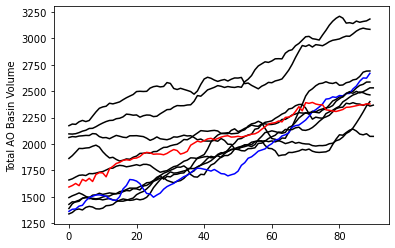

In [39]:
diff_vols = {}

for year in tqdm.trange(2011,2022):
    
    dec_sit = get_daily_flux_data(year-1,12)['sit']
    jan_sit = get_daily_flux_data(year,1)['sit']
    feb_sit = get_daily_flux_data(year,2)['sit']
    
    season = np.concatenate([dec_sit,jan_sit,feb_sit])
    
    masked_season = np.full(season.shape, np.nan)
    for i in range(season.shape[0]):
        
        s = season[i]
        masked_season[i] = mask.select_region('Beaufort',s)
        
    vols = np.nansum(masked_season,axis=(1,2))
    
    diff_vols[year] = vols
    
    
for key in diff_vols.keys():
    
    if key == 2021:
        color = 'r'
    elif key == 2018:
        color = 'b'
    else:
        color = 'k'
    
    plt.plot(diff_vols[key],color=color)
    
plt.ylabel('Total AO Basin Volume')

In [50]:
pickle.dump(diff_vols, open('../figure2/vol_fig2.p','wb'))